<a href="https://colab.research.google.com/github/UTDataMining/2022A/blob/main/lab11/Intro_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorchによるニューラルネットワークの実装
[Pytorch](https://pytorch.org/)

## Autograd
自動微分による勾配の計算

[Autograd](https://github.com/HIPS/autograd)

[Autogradチュートリアル](https://github.com/HIPS/autograd/blob/master/docs/tutorial.md)


In [34]:
def grad_sigmoid_symbolic(x):
    # Since d sigmoid(x) / dx = sigmoid(x) * (1 - sigmoid(x))
    s = sigmoid(x)
    dsdx = s * (1 - s)
    return dsdx
grad_sigmoid_symbolic(1.0) # 勾配の値（x=1.0における）

0.19661193324148185

In [ ]:
import autograd.numpy as np
from autograd import grad

Autogradによるシグモイド関数の勾配計算の例

$$
f(x) = \frac{1}{1 + e^{-x}}
$$

シグモイド関数を以下のような単純な関数の組み合わせで考える。

$$f(x) = s(c(b(a(x))))$$

$$
a(x) = -x
$$

$$
b(a) = e^a
$$

$$
c(b) = 1 + b
$$

$$
s(c) = \frac{1}{c}
$$

この時の計算グラフは以下のように表すことができる。
 
![Gradient Computation Image](https://drive.google.com/uc?export=view&id=1bvdPv0MI2eM3GeobsHFsFjLrLsibuhJa)

連鎖律を用いて入力$x$に関する関数$s$の勾配$\frac{\partial s}{\partial x}$は
$$
\frac{\partial s}{\partial x} = \frac{\partial s}{\partial c} \frac{\partial c}{\partial b} \frac{\partial b}{\partial a} \frac{\partial a}{\partial x}
$$
となります。この勾配を実際に求めてみると以下のようになります。

In [ ]:
def grad_sigmoid_manual(x):
    a = -x        
    b = np.exp(a) 
    c = 1 + b     
    s = 1.0 / c   
    
    dsdc = (-1.0 / (c**2))
    dsdb = dsdc * 1
    dsda = dsdb * np.exp(a)
    dsdx = dsda * (-1)
    
    return dsdx

grad_sigmoid_manual(1.0) # 勾配の値（x=1.0における）

0.19661193324148188

上記の手続きをAutogradで記述すると以下のようになります。

In [ ]:
def sigmoid(x): # 関数定義
  return 1.0/(1.0 + np.exp(-x))

grad_sigmoid = grad(sigmoid) # 勾配の取得　
grad_sigmoid(1.0) # 勾配の値（x=1.0における）

0.19661193324148188

有限差分による勾配を確認してみましょう。

In [ ]:
(sigmoid(1.0001) - sigmoid(0.9999)) / 0.0002 # 有限差分による勾配の確認

0.19661193318254444

## PyTorchによるAutomatic differentiation
[Autograd](https://pytorch.org/docs/stable/notes/autograd.html)


In [ ]:
import torch

In [ ]:
def f(x): # 関数定義 
    return 1.0/(1.0+torch.exp(-x))

x = torch.from_numpy(np.array([1.0])).requires_grad_(True)
# x = torch.tensor(1.0).requires_grad_(True) 
y = f(x)
y.backward() # 勾配の計算
x.grad.item()

0.19661193324148188

In [137]:
import numpy as np
import pandas as pd
iris = pd.read_csv('https://raw.githubusercontent.com/UTDataMining/2022A/master/ex8/iris.csv')
X=iris[(iris['species']=='versicolor')| (iris['species']=='virginica')][['petal_length', 'petal_width']].values
y=iris[(iris['species']=='versicolor')| (iris['species']=='virginica')][['species']].values
y = (y=='versicolor').astype(int)
X = (X-np.mean(X, axis=0))/np.std(X, axis=0)
X = np.hstack([np.ones((m,1)), X])
m = X.shape[0]
n = X.shape[1]
X = torch.from_numpy(X).to(torch.float)
y = torch.from_numpy(y).to(torch.long)

In [139]:
num_epochs = 100  # Number of epochs of training
alpha = 0.1  # Learning rate
costs = []
w = torch.zeros(n,1).requires_grad_(True)
for i in range(num_epochs):
    f = torch.mm(X,w)
    # f = X@w
    g = 1/(1+torch.exp(-f))
    loss =  (-1 / m) * torch.sum(y*torch.log(g)+(1-y)*torch.log(1-g))
    loss.backward()
    costs.append(loss.item())    
    # Update parameters w and b
    with torch.no_grad():
        w.data = w - alpha * w.grad
        #w -= alpha * w.grad
        w.grad.zero_()
print(w.detach().cpu().numpy())
print(costs[-1])

[[-0.02318852]
 [-1.2888526 ]
 [-1.4116936 ]]
0.19912463426589966


In [170]:
X=iris[(iris['species']=='versicolor')| (iris['species']=='virginica')][['petal_length', 'petal_width']].values
y=iris[(iris['species']=='versicolor')| (iris['species']=='virginica')][['species']].values
y = (y=='versicolor').astype(int)
X = (X-np.mean(X, axis=0))/np.std(X, axis=0)
n = X.shape[1]
X = torch.from_numpy(X).to(torch.float)
y = torch.from_numpy(y).to(torch.float)

In [173]:
class MyModel(torch.nn.Module):
    def __init__(self, input_size):
        super(MyModel, self).__init__()
        self.linear = torch.nn.Linear(input_size, 1)
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

In [179]:
num_epochs = 100  # Number of epochs of training
lr = 0.1  # Learning rate
model = MyModel(n)
cost = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
for i in range(num_epochs):
    optimizer.zero_grad()
    loss = cost(model(X), y)
    loss.backward()
    optimizer.step()
for param in model.parameters():
  print(param.detach().cpu().numpy())
print(loss.item())

[[-1.2798562 -1.3476255]]
[-0.12275416]
0.20409250259399414


## マルチレイヤーパーセプトロンによる手書き数字画像認識の例

実行の前にメニューの

ランタイム -> ランタイムのタイプの変更　

でハードウェアアクセラレータをGPUにしてください

In [ ]:
# グラフを動的に可視化するモジュール
!pip install livelossplot 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from livelossplot import PlotLosses

In [ ]:
# データセット
mnist_train = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



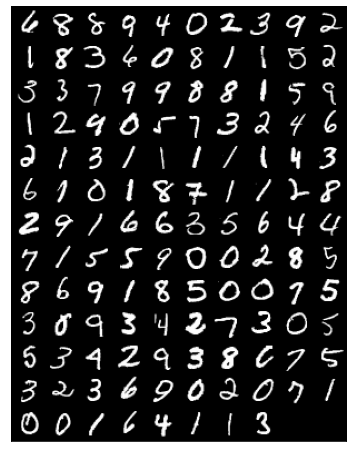

In [ ]:
train_bs = 128 # 訓練データのバッチサイズ
test_bs = 100 # テストデータのバッチサイズ

# データローダ
train_dl = DataLoader(mnist_train, batch_size = train_bs, shuffle=True)
test_dl = DataLoader(mnist_test, batch_size = test_bs)

dataiter = iter(train_dl)
images, labels = next(dataiter)
viz = torchvision.utils.make_grid(images, nrow=10, padding = 2).numpy()
fig, ax = plt.subplots(figsize= (8,8))
ax.imshow(np.transpose(viz, (1,2,0)))
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [ ]:
import math
import math
%matplotlib inline

In [ ]:
def model(xb, weights, bias):
    x = xb @ weights + bias      
    return x - x.exp().sum(-1).log().unsqueeze(-1) # softmaxの対数

def loss_func(input, target): # 負の対数尤度
    # input (prediction) shape = (batch_size, 10)
    # target shape = (batch_size,)
    # input[range(batch_size), target] shape = (batch_size,)
    return -input[range(target.shape[0]), target].mean()

In [ ]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds==yb).float().mean()

def num_correct(out, yb):
    preds = torch.argmax(out, dim=1)
    return torch.sum(preds == yb)

def eval_performance(dl, weights, bias):
    total_samples = 0
    total_correct = 0

    for xb, yb in dl:
        xb = xb.view(xb.size(0), -1)

        preds = model(xb, weights, bias)
        correct = num_correct(preds, yb)

        total_correct += correct
        total_samples += len(yb)

    return total_correct / float(total_samples)

In [ ]:
lr = 0.1
epochs = 5

in_shape = 784
out_shape = 10

# Initialize weights
weights = torch.randn(in_shape, out_shape) / math.sqrt(in_shape)
weights.requires_grad_()
bias = torch.zeros(out_shape, requires_grad=True)

for epoch in range(epochs):
    for i, (xb, yb) in enumerate(train_dl):    
        xb = xb.view(xb.size(0), -1)
            
        # Forward pass    
        pred = model(xb, weights, bias)
        loss = loss_func(pred, yb)

        # Backward pass
        loss.backward()
        with torch.no_grad():   # temporarily sets all the requires_grad flags to False
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()
            
    train_acc = eval_performance(train_dl, weights, bias)
    test_acc = eval_performance(test_dl, weights, bias)
    print("Epoch: {} | Train Acc: {} | Test Acc: {}".format(epoch + 1, train_acc, test_acc))

Epoch: 1 | Train Acc: 0.88878333568573 | Test Acc: 0.897599995136261
Epoch: 2 | Train Acc: 0.9005833268165588 | Test Acc: 0.9077000021934509
Epoch: 3 | Train Acc: 0.9065499901771545 | Test Acc: 0.9115999937057495
Epoch: 4 | Train Acc: 0.9107000231742859 | Test Acc: 0.9147999882698059
Epoch: 5 | Train Acc: 0.9131166934967041 | Test Acc: 0.916100025177002


In [ ]:
# ネットワーク定義
dim_x = 784 # 入力層のユニット数（28x28のピクセル）
dim_h = 100 # 隠れ層のユニット数
dim_out = 10 # 出力層のユニット数（クラス数）

model = torch.nn.Sequential()
model.add_module('fc1', torch.nn.Linear(dim_x, dim_h)) # 入力層-隠れ層
model.add_module('relu1', torch.nn.ReLU()) # 活性関数ReLU
#model.add_module('dropout1',torch.nn.Dropout()) # ドロップアウト
model.add_module('fc2', torch.nn.Linear(dim_h, dim_out)) # 隠れ層-出力層
print(model)

Sequential(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)


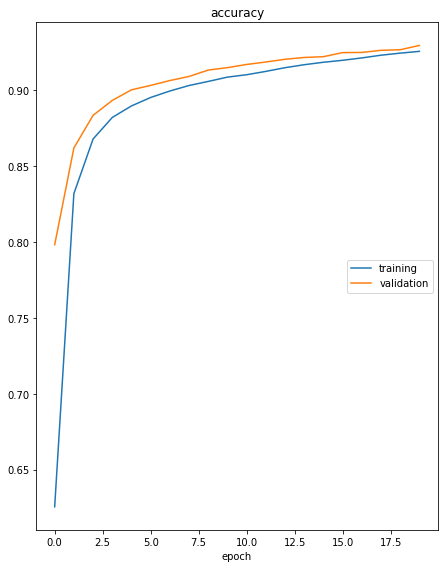

accuracy
	training         	 (min:    0.626, max:    0.925, cur:    0.925)
	validation       	 (min:    0.798, max:    0.929, cur:    0.929)


In [ ]:
# GPUsの使用
if torch.cuda.is_available():
    print("Using cuda")
    use_cuda = True
    device = torch.device("cuda")
else:
    device = "cpu"

learning_rate = 1e-2 # 学習率
epochs = 20 # エポック数

# 最適化法（SGD）
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss() # 損失関数
model.to(device) # モデルをGPUへ
model.train() # 訓練モード
liveloss = PlotLosses() # グラフ可視化

# エポック数繰り返し
for epoch in range(epochs):
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    model.train() # 訓練モード
    for i, (X_train, y_train) in enumerate(train_dl):
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        X_train = X_train.view(X_train.size(0), -1)
        
        # forward
        y_pred = model(X_train) 
        loss = loss_fn(y_pred, y_train) # 損失
        preds = torch.argmax(y_pred, dim=1)
        acc = (preds==y_train).float().mean()       
        train_loss.append(loss.item())
        train_acc.append(acc.item())

        # backward 
        model.zero_grad() # またはoptimizer.zero_grad() 勾配初期化
        loss.backward() # 勾配計算
        optimizer.step() # パラメータ更新
    
    model.eval() # 評価モード    
    for i, (X_test, y_test) in enumerate(test_dl):
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        X_test = X_test.view(X_test.size(0), -1)
        y_pred = model(X_test) 
        loss = loss_fn(y_pred, y_test) # 損失
        preds = torch.argmax(y_pred, dim=1)
        acc = (preds==y_test).float().mean() # 精度        
        test_loss.append(loss.item())
        test_acc.append(acc.item())
    
    #print(epoch+1, np.array(train_loss).mean(), np.array(train_acc).mean()) # 訓練誤差
    #print(epoch+1, np.array(test_loss).mean(), np.array(test_acc).mean()) # テスト誤差
    
    liveloss.update({
        'accuracy': np.array(train_acc).mean(),
        'val_accuracy': np.array(test_acc).mean()
    })
    liveloss.draw()

## モデル選択・パラメータ最適化

In [ ]:
# ネットワークの定義
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation_func=torch.nn.functional.relu):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim) # 入力層-隠れ層1
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)  # 隠れ層1-隠れ層2
        self.fc3 = torch.nn.Linear(hidden_dim, output_dim)  # 隠れ層2-出力層
        self.activation_func = activation_func # 活性化関数
    
    def forward(self, x):
        h1 = self.activation_func(self.fc1(x))
        h2 = self.activation_func(self.fc2(h1))
        out = self.fc3(h2)
        return out

In [ ]:
# モデル訓練
def train_model(model, optimizer, train_loader, test_loader, epochs=10):
  if torch.cuda.is_available():
      print("Using cuda")
      use_cuda = True
      device = torch.device("cuda")
  else:
      device = "cpu"

  loss_fn = torch.nn.CrossEntropyLoss()
  model.to(device)    
  model.train()
  liveloss = PlotLosses()
  
  for epoch in range(epochs):

    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    model.train() # 訓練モード
    for i, (X_train, y_train) in enumerate(train_dl):
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        X_train = X_train.view(X_train.size(0), -1)
        
        # forward
        y_pred = model(X_train) 
        loss = loss_fn(y_pred, y_train) # 損失
        preds = torch.argmax(y_pred, dim=1)
        acc = (preds==y_train).float().mean()
        train_loss.append(loss.item())
        train_acc.append(acc.item())

        # backward 
        model.zero_grad() # またはoptimizer.zero_grad() 勾配初期化
        loss.backward() # 勾配計算
        optimizer.step() # パラメータ更新
    
    model.eval() # 評価モード
    for i, (X_test, y_test) in enumerate(test_dl):
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        X_test = X_test.view(X_test.size(0), -1)

        y_pred = model(X_test) 
        loss = loss_fn(y_pred, y_test) # 損失
        preds = torch.argmax(y_pred, dim=1)
        acc = (preds==y_test).float().mean()
        test_loss.append(loss.item())
        test_acc.append(acc.item())
    
    #print(epoch+1, np.array(train_loss).mean(), np.array(train_acc).mean()) # 訓練誤差
    #print(epoch+1, np.array(test_loss).mean(), np.array(test_acc).mean()) # テスト誤差
    
    liveloss.update({
        'accuracy': np.array(train_acc).mean(),
        'val_accuracy': np.array(test_acc).mean()
    })
    liveloss.draw()

In [ ]:
# パラメータ初期化方法
def init_weights_xavier(m): #
  if type(m) == torch.nn.Linear:
    torch.nn.init.xavier_normal_(m.weight)

def init_weights_kaiminghe(m): # 
  if type(m) == torch.nn.Linear:
    torch.nn.init.kaiming_normal_(m.weight)

以下を変更してみてください
- 隠れ層のユニット数
- 隠れ層の数
- 活性化関数 [functional](https://pytorch.org/docs/stable/nn.functional.html)
- パラメータの初期化方法 [init](https://pytorch.org/docs/stable/nn.init.html)
- 最適化方法 [optim](https://pytorch.org/docs/stable/optim.html)
- 学習率
- エポック数

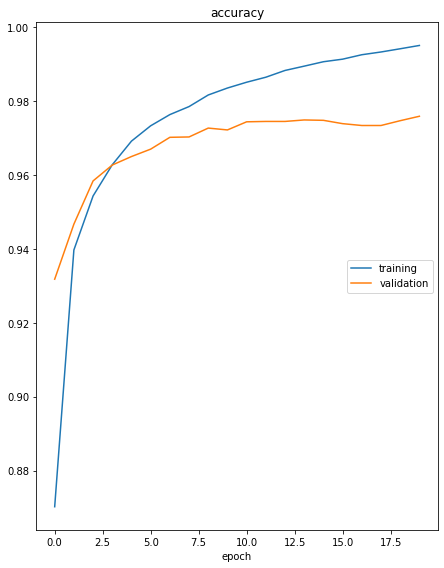

accuracy
	training         	 (min:    0.870, max:    0.995, cur:    0.995)
	validation       	 (min:    0.932, max:    0.976, cur:    0.976)


In [ ]:
train_bs = 128 # 訓練データのバッチサイズ
test_bs = 100 # テストデータのバッチサイズ
train_dl = DataLoader(mnist_train, batch_size = train_bs, shuffle=True)
test_dl = DataLoader(mnist_test, batch_size =test_bs)

dim_x = 784 # 入力層のユニット数（28x28の画像）
dim_h = 100 # 隠れ層のユニット数
dim_out = 10 # 出力層のユニット数（クラス数）

# 活性化関数
activation_func = torch.nn.functional.relu
model = Net(dim_x, dim_h, dim_out, activation_func)

# パラメータ初期化
model = model.apply(init_weights_kaiminghe)

# 最適化法
params = model.parameters()
learning_rate = 0.01 # 学習率
momentum = 0.9 # モーメンタム
optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=momentum)
#optimizer = torch.optim.RMSprop(params, learning_rate)
#optimizer = torch.optim.Adam(params, learning_rate)

epochs = 20 # エポック数  
train_model(model, optimizer, train_dl, test_dl, epochs=epochs)